<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/Replication_of_RL_Lateral_Controller_for_Autonomous_Vehicles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [2]:
!pip install pygame
!pip install highway-env

Testing

In [3]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np


from IPython.display import Image, display
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
%matplotlib inline

Environment Definition

In [4]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

In [5]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs,a):
    self.obs = obs
    self.a = a

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
    # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
    ego_vehicle = env.unwrapped.vehicle
    lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]
    if lead_vehicle:
      gap = lead_vehicle.position[0] - ego_vehicle.position[0]
      delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
      self.longitudinal_lead_state = {"x": gap, "vx": delta_velocity}

    else:
      self.longitudinal_lead_state = {"x": 10, "vx": 0}

    return self.longitudinal_lead_state

  #Reward Function
  def reward_function(self, action, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
    """
    Reward Function:

    Acceleration Reward: r_acce = w1*f_acce(a_yaw)
    a_yaw = lateral acceleration (self.action)

    Rate Reward: r_rate = w2*f_rate(w_yaw)
    w_yaw = lateral rate (vy)

    Time Reward: r_time = w3*f_time (delta_lat_deviation)
    delta_lat_deviation = change in lateral deviation (self.lat_off)

    Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

    """
    self.target_id = ("0","1",target_id)
    target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
    vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
    _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

    self.action = action
    w_yaw = obs_new[0][3]-obs_old[0][3]

    # Acceleration Reward
    acce_reward = -1*abs(self.action)

    # Rate Reward
    rate_reward = -1*abs(w_yaw)

    # Time Reward
    time_reward = -0.05 * abs(self.delta_lat_deviaton)

    # Overall Reward
    self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

    return [self.reward, acce_reward, rate_reward, time_reward]

  #Acceleration to Steering angle
  def steering_angle(self, agent_action,L=1):
    """
    Steering Angle: theta = atan(a_yaw/v^2)
    a_yaw = lateral acceleration (agent_action)
    v = vehicle speed (vx)
    """
    self.angle = math.atan(L*agent_action/self.ego_state_idm()['vx']**2)

    return self.angle

Agent Defintion

In [42]:
class Agent(nn.Module):
  """
  s = (x, y, vx, vy, thetha, lane_width, lane_id, self_curvature, longitudinal_acceleration) ∈ S

  Lateral Agent State:
  x = vehicle x position
  y = vehicle y position
  vx = vehicle speed (longitudinal)
  thetha = yaw angle (heading)
  lane_width = width of the lane
  lane_id = target lane id
  self_curvature = road curvature at the vehicle's position
  longitudinal_acceleration = vehicle longitudinal acceleration
  """
  def __init__(self, state_dim):
    super(Agent, self).__init__()
    self.state_dim = state_dim
    # Define Network A & C
    self.networkA = nn.Sequential(
        nn.Linear(self.state_dim, 100),
        nn.Linear(100, 1),
        nn.Softplus()
    )
    self.networkC = nn.Sequential(
        nn.Linear(self.state_dim + 1, 100),
        nn.ReLU(),
        nn.Linear(100, 1),
    )

    # Define Network B
    self.networkB1 = nn.Sequential(
        nn.Linear(self.state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1),
    )
    self.networkB2 = nn.Sequential(
        nn.Linear(self.state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1),
    )
    self.networkB3 = nn.Sequential(
        nn.Linear(self.state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1),
    )

  def forward(self, state, a, terminal):
    """
    Q(s,a) = A(s)*(B(s)-a)^2 + C(s)
    """
    if isinstance(state, dict):
      state_tensor = torch.tensor(
          [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
          dtype=torch.float32
      ).unsqueeze(0)
    else:
        self.state = state
    # Use a directly if it's already a tensor
    self.a = a if isinstance(a, torch.Tensor) else torch.tensor([[a]], dtype=torch.float32)
    self.terminal_condition = terminal if isinstance(terminal, torch.Tensor) else torch.tensor([[terminal]], dtype=torch.float32)

    # Output of the Networks
    self.A = -self.networkA(self.state)
    self.C = self.networkC(torch.concat((self.state, self.terminal_condition), dim=1))
    self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))

    # Q-function Approximation
    q_value = self.A * ((self.B - self.a) ** 2) + self.C

    return q_value

  def action(self, state):
      # Convert it to a tensor
      if isinstance(state, dict):
          state_tensor = torch.tensor(
              [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
              dtype=torch.float32
          ).unsqueeze(0)
      else:
          state_tensor = state
      self.state = state_tensor
      self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))
      return self.B

Experience Buffer

In [7]:
# Buffer Class
class Experience_Buffer():
  """
  Define Experience Buffer
  """
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    # Define Buffer as Deque with Limit of Default Size buffer_size elements
    self.buffer = deque(maxlen=self.buffer_size)

  def add(self, state, action, reward, next_state, terminal_condition):
    # Experience is the state transition tensor/vector
    state_tensor = torch.tensor(
        [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
        dtype=torch.float32
    ).unsqueeze(0)
    next_state_tensor = torch.tensor(
        [next_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
        dtype=torch.float32
    ).unsqueeze(0)
    action_tensor = torch.tensor([[action]], dtype=torch.float32)
    reward_tensor = torch.tensor([[reward]], dtype=torch.float32)
    terminal_tensor = torch.tensor([[terminal_condition]], dtype=torch.float32)

    self.transition = torch.concat((state_tensor, action_tensor, reward_tensor,
                                    next_state_tensor, terminal_tensor), dim=1)
    self.buffer.append(self.transition)

  def sample_experience(self, batch_size):
    # Randomly sample Experience from buffer
    batch = random.sample(self.buffer, batch_size)
    return batch

  def size(self):
    # Return the current number of elements in the buffer.
    return len(self.buffer)


Lateral Controller (Gap Checker)

In [8]:
class Gap_Controller(env.__class__):
    def __init__(self, obs=None):
        if obs is not None:
            self.obs = obs

    def lane_checker(self, safety_threshold=10.0):
        """
        Finds adjacent lane (A=Left, B=Right) where the closest vehicle
        in that lane is furthest away (maximizing minimum distance),
        and above a safety threshold. Returns the index of the best lane,
        or current lane index if no suitable option.
        """
        unwrapped_env = env.unwrapped
        vehicle = unwrapped_env.vehicle
        network = unwrapped_env.road.network
        ego_pos = vehicle.position

        env_config = unwrapped_env.config

        try:
            origin, dest, current_idx = network.get_closest_lane_index(ego_pos)
        except Exception:
            print("Error: Cannot determine current vehicle lane.")
            return None

        lanes_to_check = {}
        # Lane A (Left)
        if current_idx < env_config["lanes_count"] - 1:
            lanes_to_check['left'] = (origin, dest, current_idx + 1)
        # Lane B (Right)
        if current_idx > 0:
            lanes_to_check['right'] = (origin, dest, current_idx - 1)

        if not lanes_to_check:
            return current_idx

        lane_min_distances = {}
        for direction, lane_tuple in lanes_to_check.items():
            min_dist_sq_in_lane = float('inf')
            found_vehicle_in_lane = False
            try:
                target_lane = network.get_lane(lane_tuple)
                for veh in unwrapped_env.road.vehicles:
                    if veh is vehicle: continue
                    try:
                        if network.get_closest_lane_index(veh.position) == lane_tuple:
                            found_vehicle_in_lane = True
                            dist_sq = np.sum((veh.position - ego_pos)**2)
                            min_dist_sq_in_lane = min(min_dist_sq_in_lane, dist_sq)
                    except Exception: continue
            except KeyError:
                continue

            lane_min_distances[direction] = math.sqrt(min_dist_sq_in_lane) if found_vehicle_in_lane else float('inf')

        best_lane_idx = current_idx
        max_of_min_dist = -1.0

        # Check Left Lane
        if 'left' in lane_min_distances and lane_min_distances['left'] >= safety_threshold:
            if lane_min_distances['left'] > max_of_min_dist :
                max_of_min_dist = lane_min_distances['left']
                best_lane_idx = lanes_to_check['left'][2]

        # Check Right Lane
        if 'right' in lane_min_distances and lane_min_distances['right'] >= safety_threshold:
            if lane_min_distances['right'] > max_of_min_dist :
                best_lane_idx = lanes_to_check['right'][2]

        return best_lane_idx


Longitudinal Controller

In [9]:
class IDM():
    ''' Intelligent Driving Model for Longitudinal Control

    Control parameters:
      a: maximum acceleration
      b: comfortable deceleration
      delta: acceleration exponent
      T: safe time headway

    Parameters:
      s0: minimum gap
      v0: desired speed

      a (Maximum Acceleration): How fast the vehicle can speed up (m/s²).
      b (Comfortable Deceleration): How smoothly the vehicle slows down (m/s²).
      δ (Acceleration Exponent): The non-linearity factor in acceleration.
      T (Safe Time Headway): The desired minimum following time gap (s).

    Input variables:
      s: current gap
      v: current vehicle speed
      delta_v: relative speed (difference between the vehicle's speed and the leading vehicle's speed)
    '''

    def __init__(self, desired_parameters, control_parameters):
        # Unpack initial parameters: [s0, v0]
        self.s0, self.v0 = desired_parameters
        # Unpack control parameters: [a, b, delta, T]
        self.a, self.b, self.delta, self.T = control_parameters

    def longitudinal_controller(self, input_variables):
        # Unpack input variables: [s, v, delta_v]
        s, v, delta_v = input_variables

        # Small epsilon to account for very small gaps and avoid division by zero
        epsilon = 1e-6

        # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
        desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

        # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
        acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

        return acceleration

Initialize Environment

In [10]:
# Initialize Environment
obs, _ = env.reset()

# Initialize Environment Manager and Reward
state_manager = ENV(obs,obs[0][2])

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

# Initial Longitundinal Positions
ego_position_idm = ego_state_idm['x']
lead_position_idm = lead_state['x']

# Initial Velocities (using vx for longitudinal control)
ego_velocity_idm = ego_state_idm['vx']
lead_velocity_idm = lead_state['vx']

Training Loop

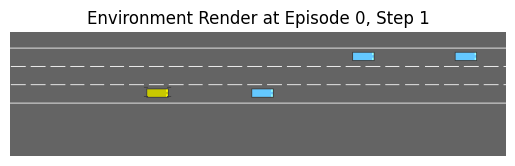

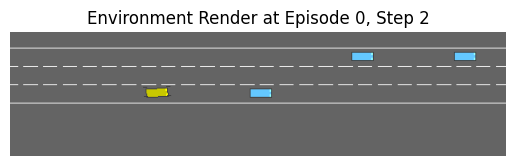

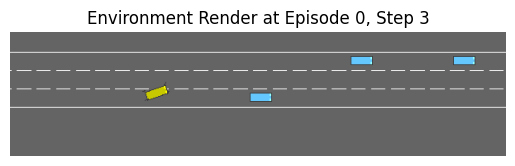

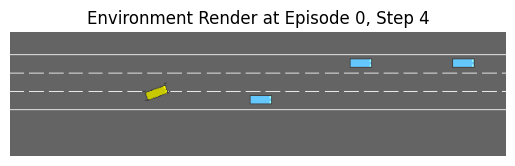

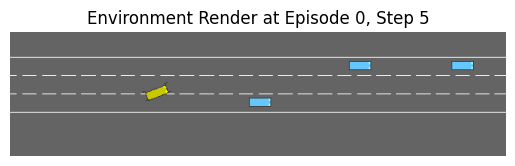

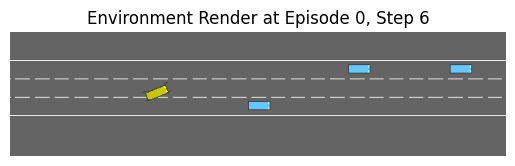

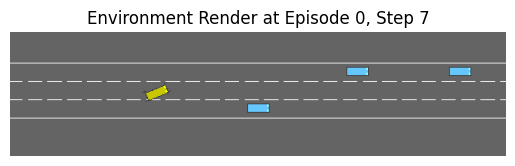

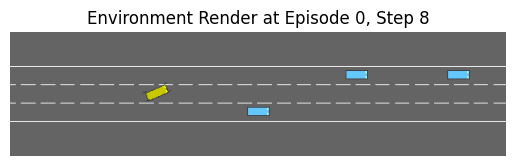

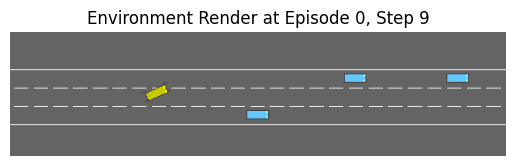

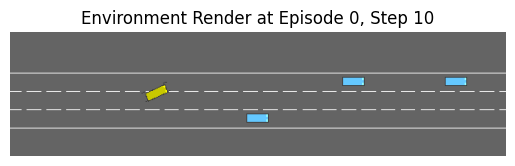

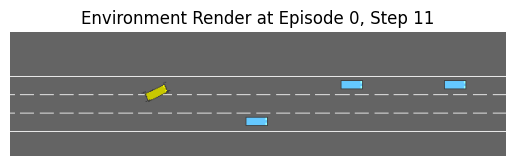

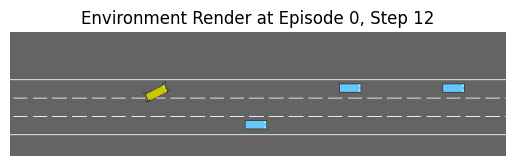

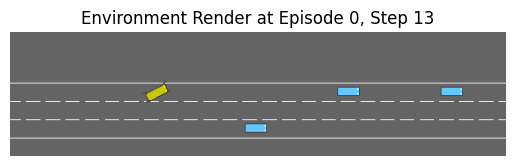

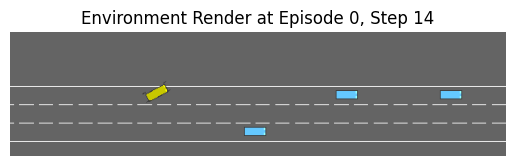

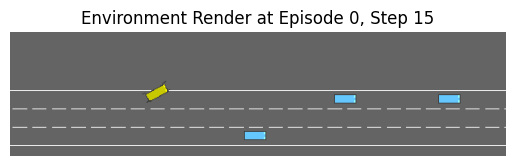

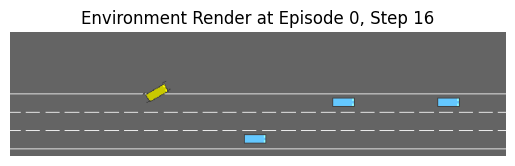

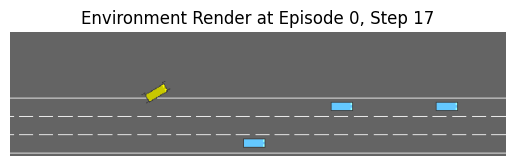

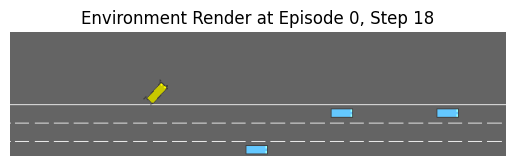

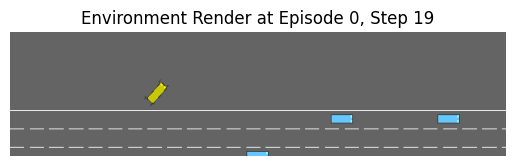

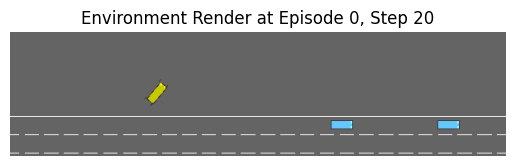

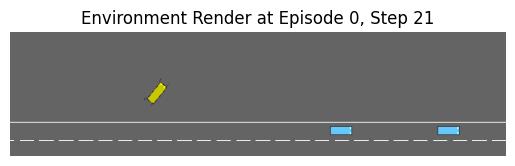

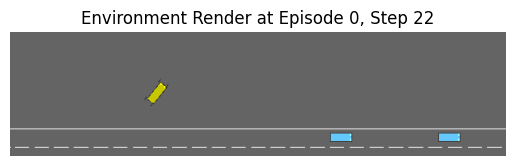

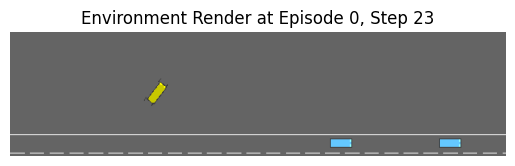

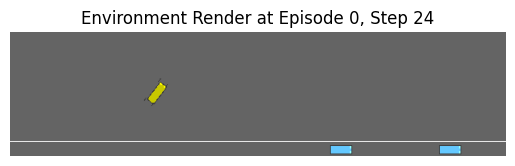

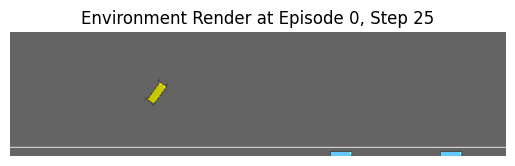

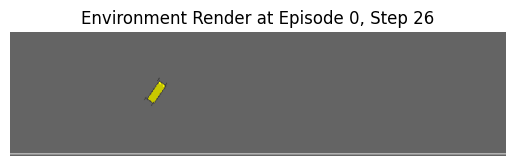

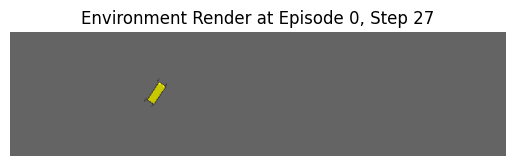

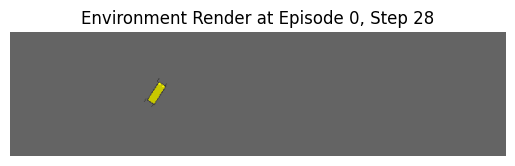

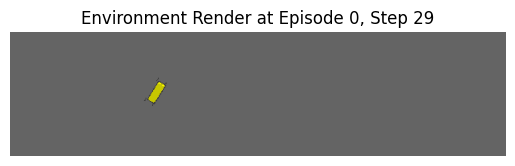

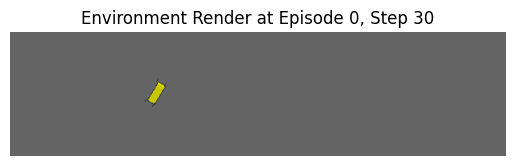

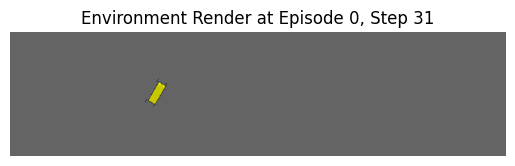

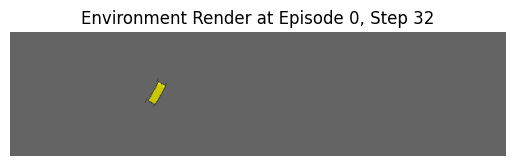

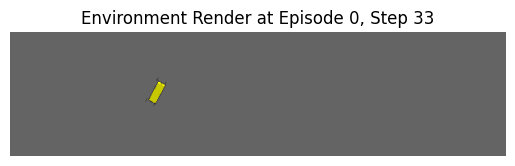

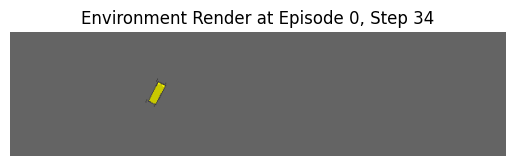

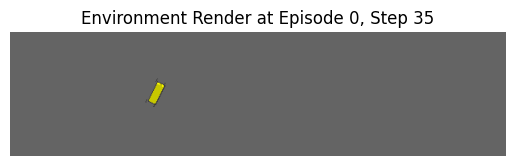

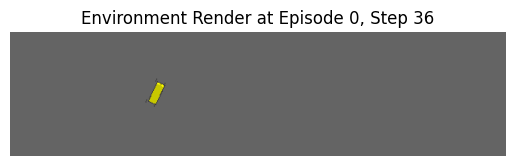

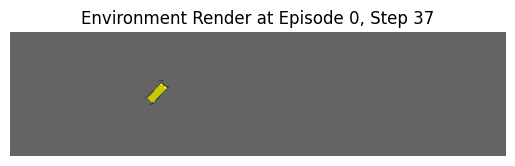

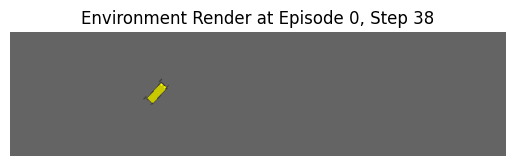

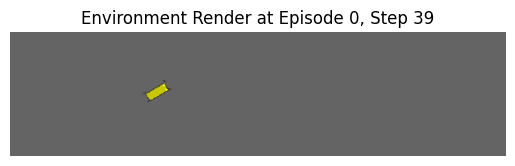

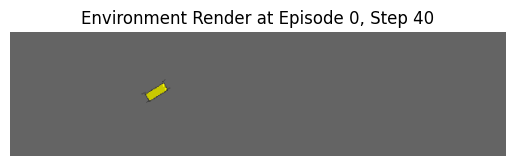

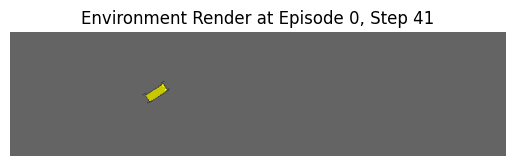

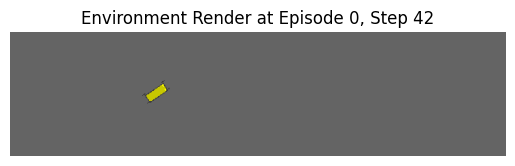

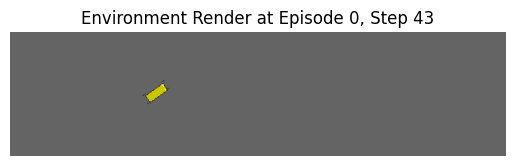

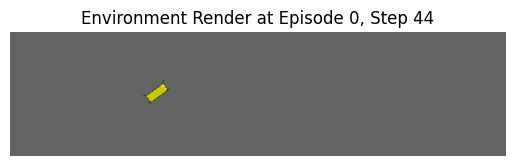

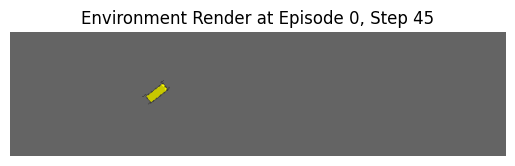

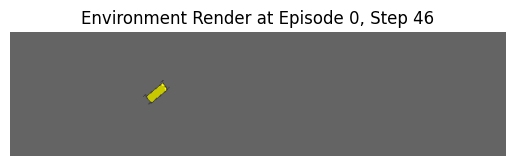

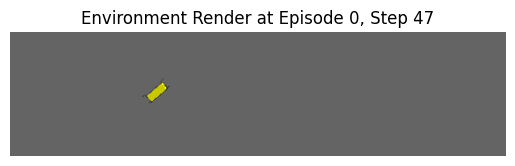

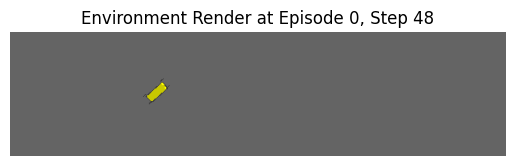

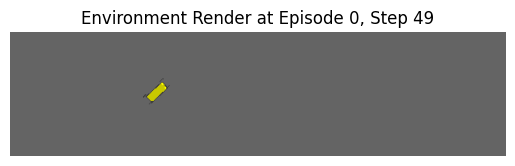

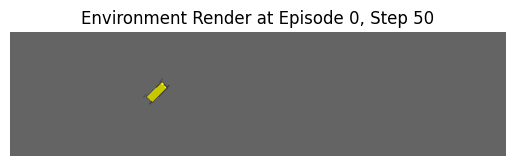

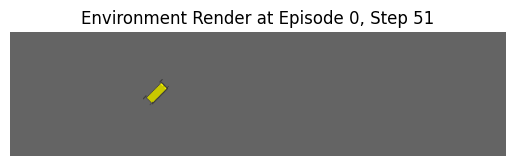

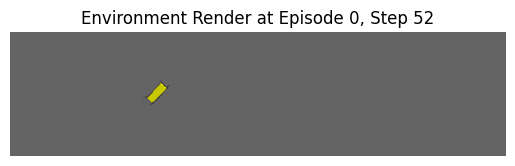

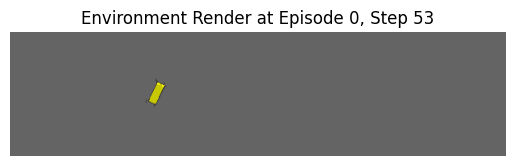

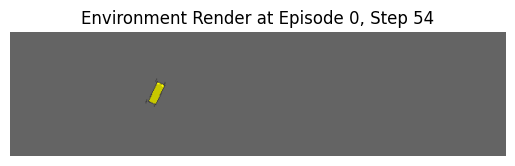

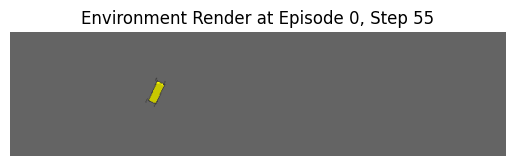

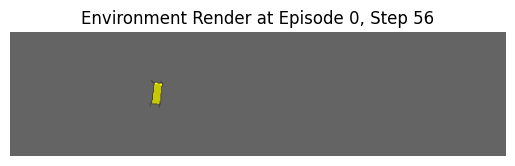

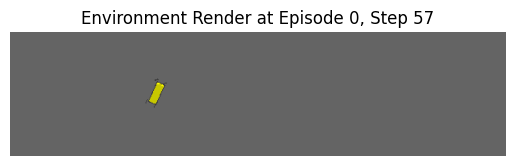

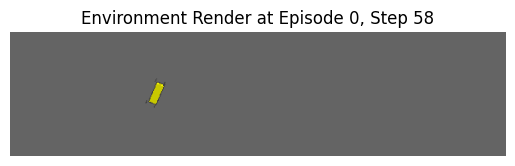

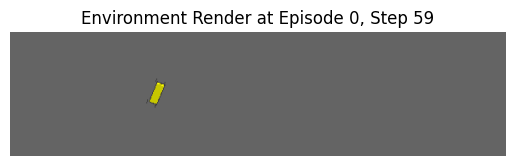

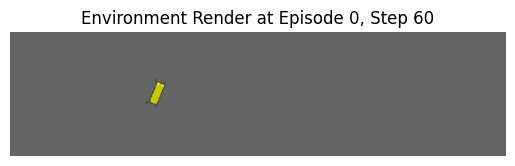

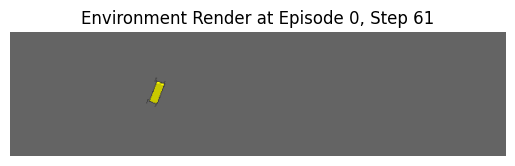

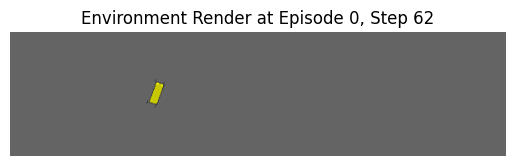

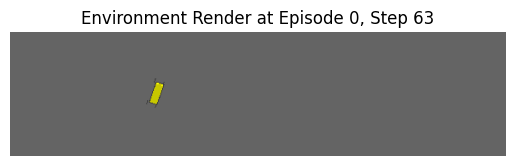

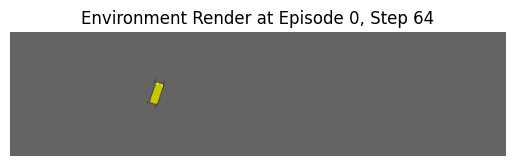

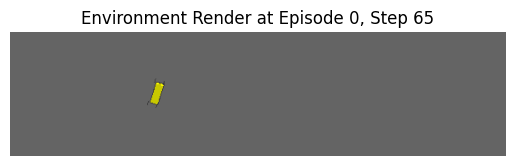

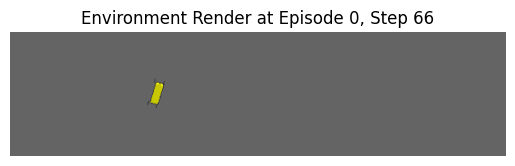

**** Target network updated at episode 0 ****
Episode 0 finished after 66 steps. Total Reward: -46.58
Episode 1 finished after 112 steps. Total Reward: -2066.57
Avg Loss (last 112 steps): 63.6460
Episode 2 finished after 119 steps. Total Reward: -11048.85
Avg Loss (last 119 steps): 844.3478
Episode 3 finished after 68 steps. Total Reward: -230.70
Avg Loss (last 68 steps): 2269.9727
Episode 4 finished after 94 steps. Total Reward: -8473.35
Avg Loss (last 94 steps): 2446.4238
Episode 5 finished after 82 steps. Total Reward: -7747.81
Avg Loss (last 82 steps): 2086.5540
Episode 6 finished after 65 steps. Total Reward: -6083.31
Avg Loss (last 65 steps): 1824.5963
Episode 7 finished after 222 steps. Total Reward: -26286.20
Avg Loss (last 222 steps): 1779.5821
Episode 8 finished after 68 steps. Total Reward: -6704.69
Avg Loss (last 68 steps): 1674.6255
Episode 9 finished after 108 steps. Total Reward: -10363.57
Avg Loss (last 108 steps): 1625.9134


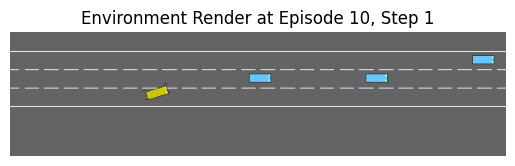

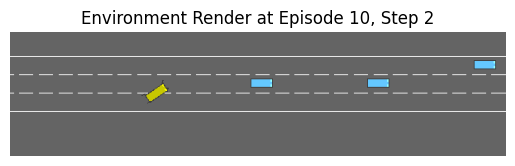

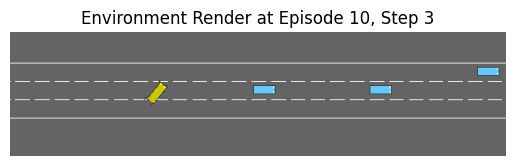

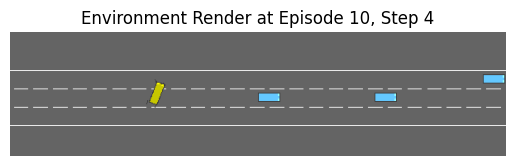

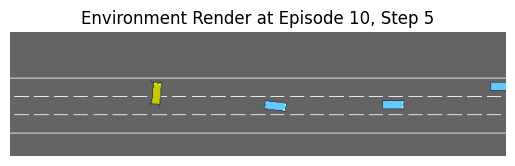

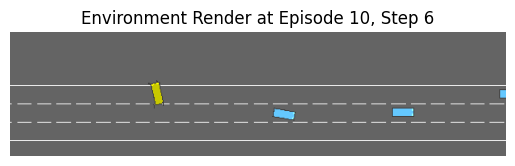

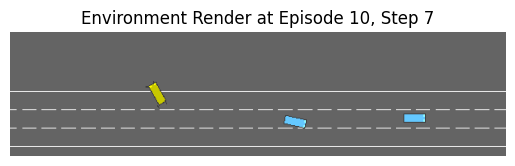

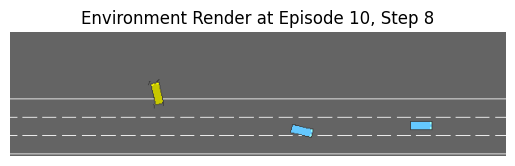

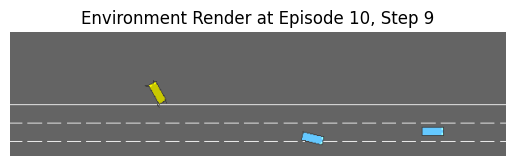

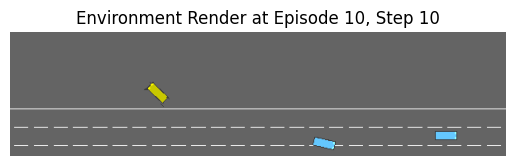

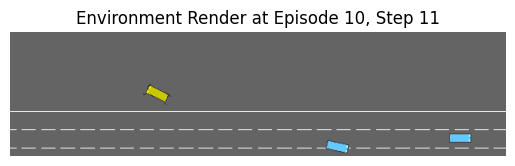

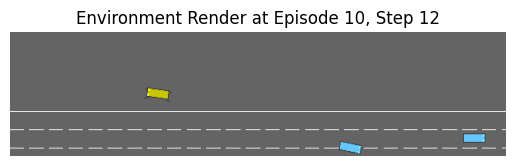

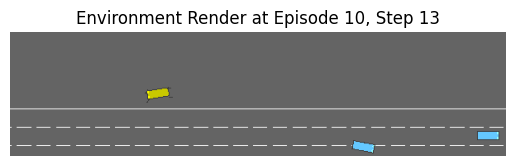

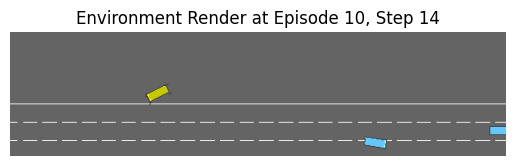

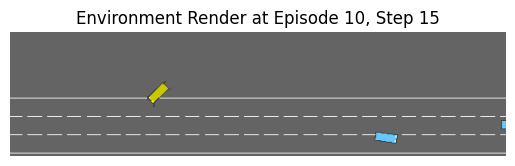

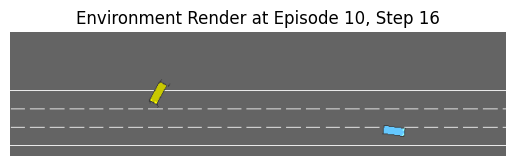

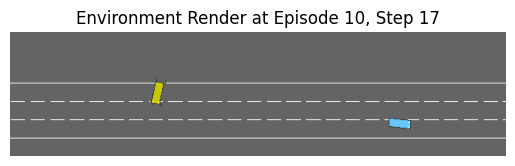

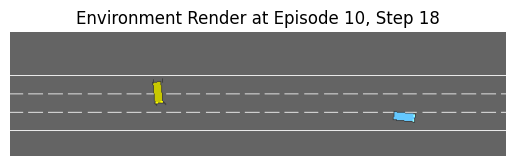

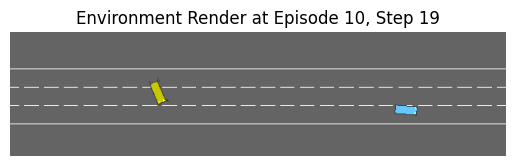

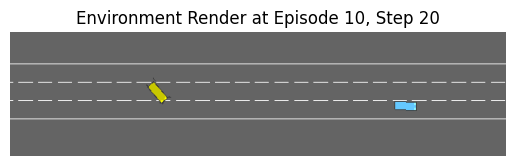

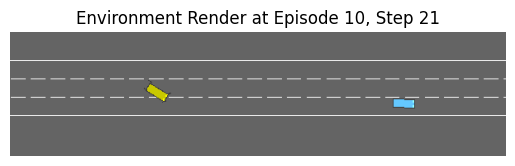

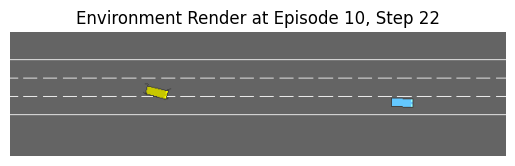

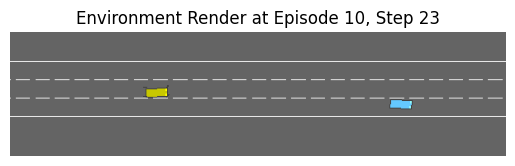

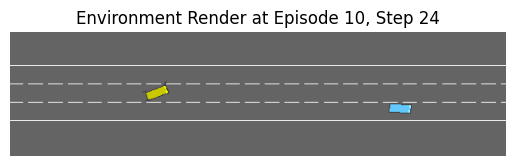

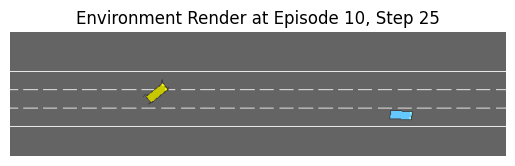

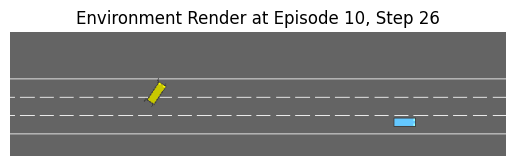

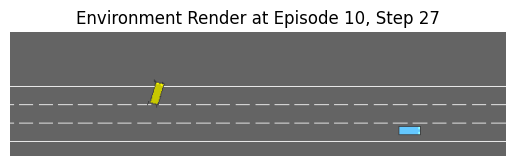

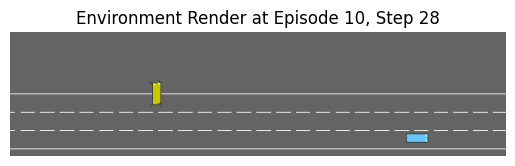

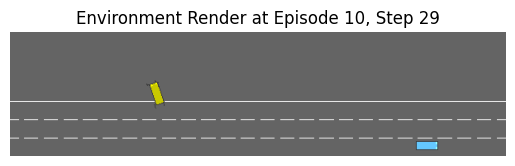

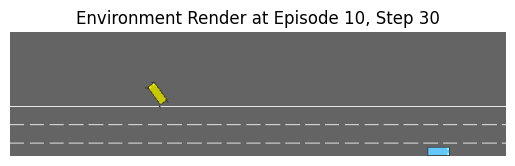

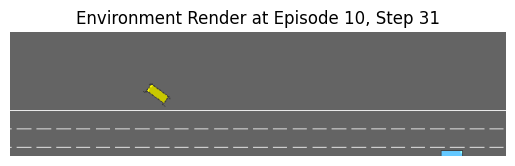

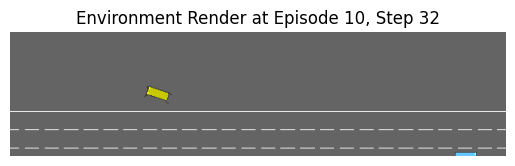

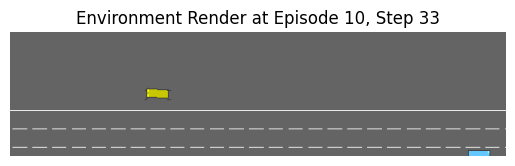

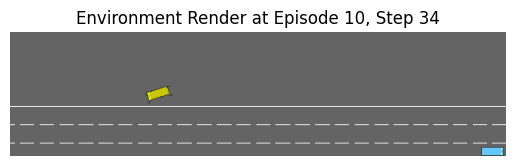

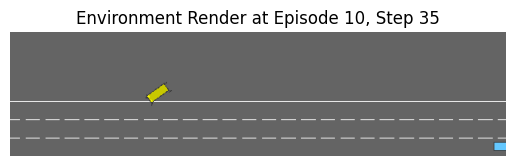

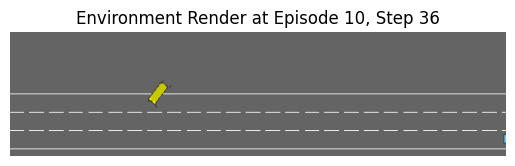

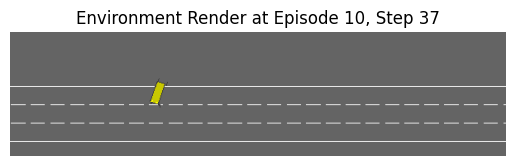

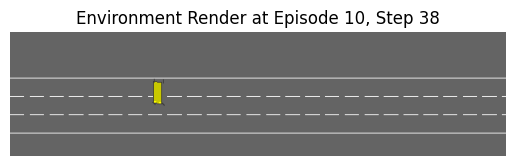

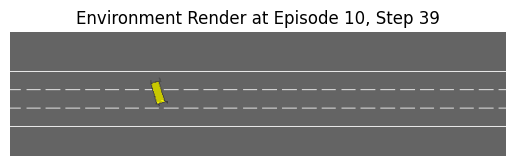

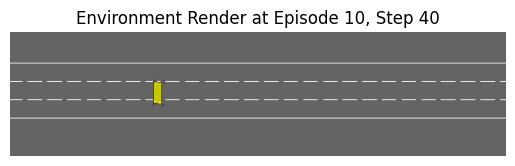

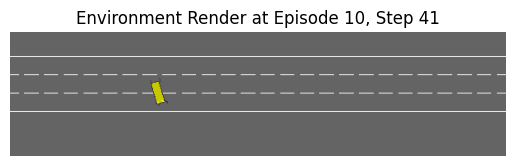

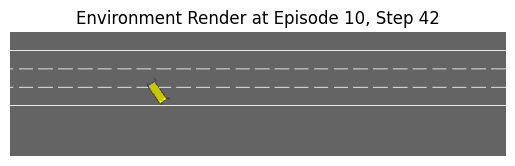

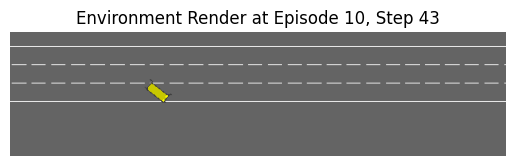

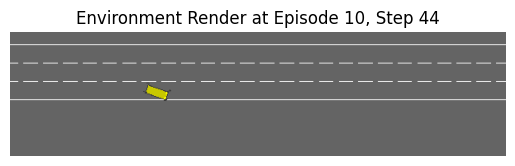

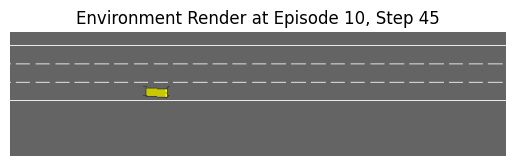

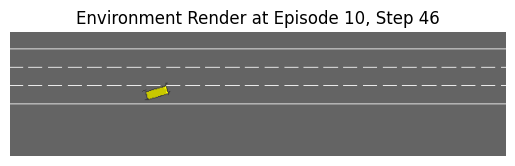

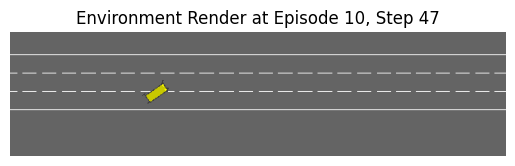

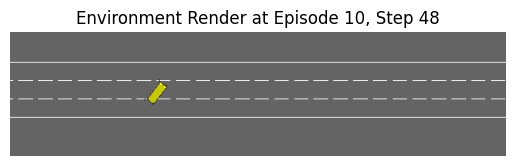

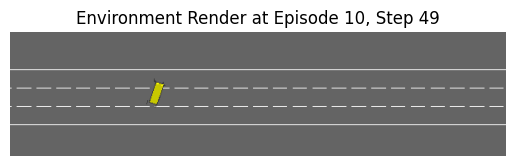

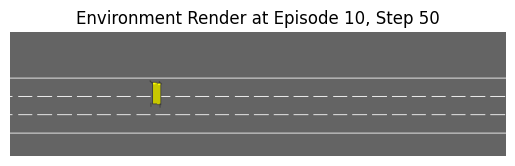

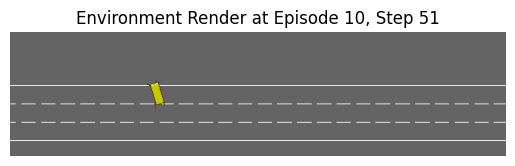

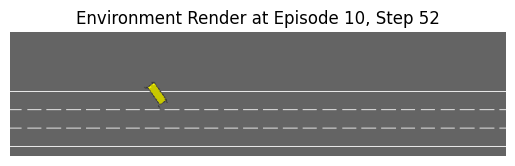

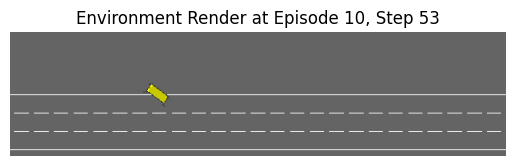

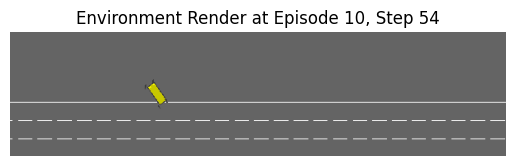

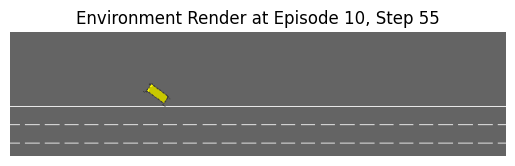

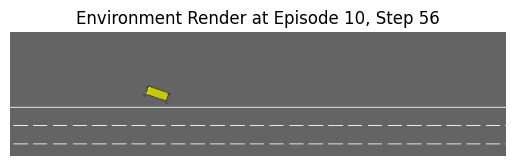

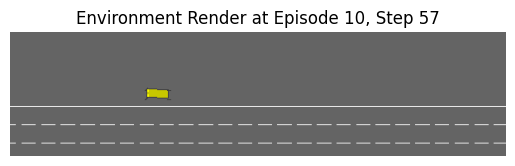

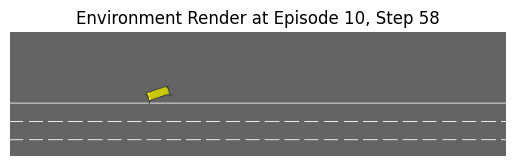

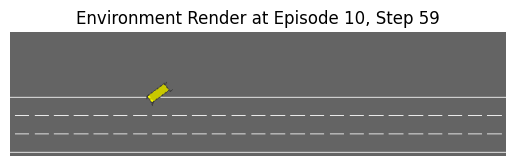

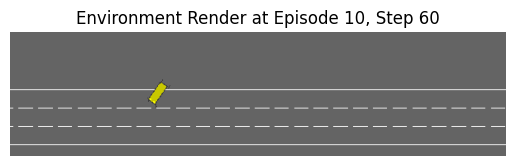

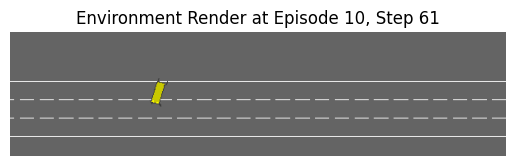

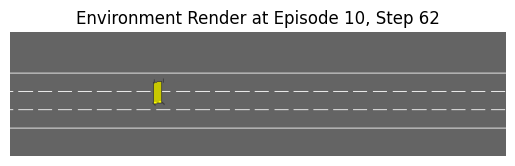

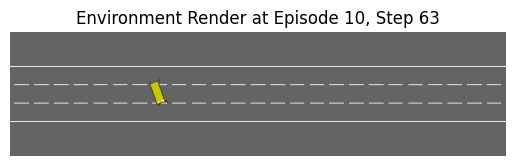

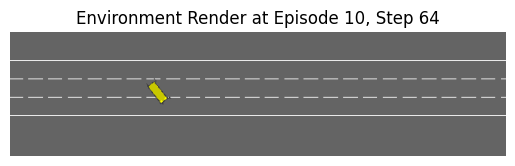

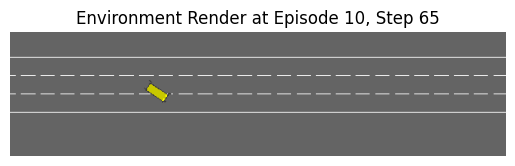

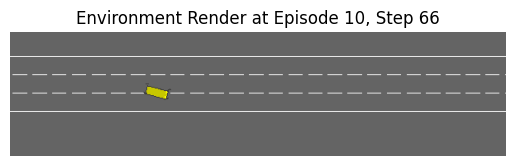

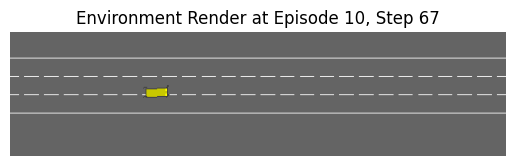

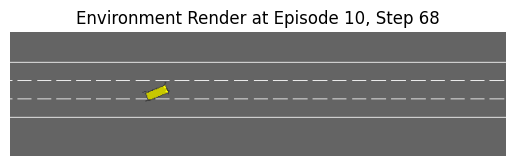

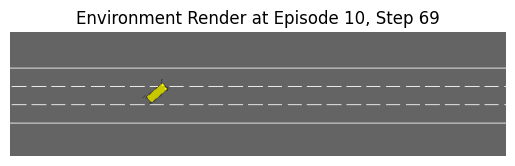

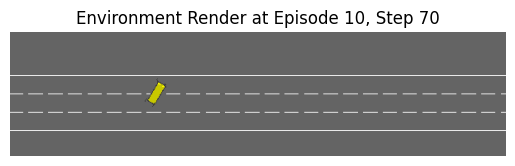

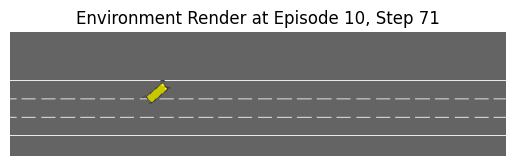

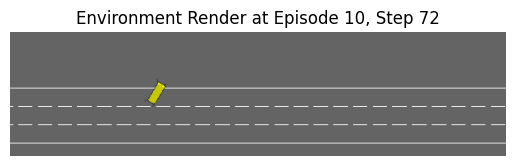

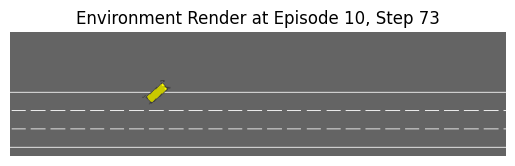

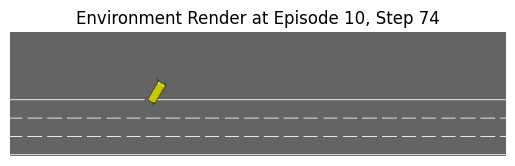

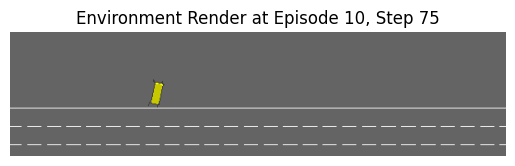

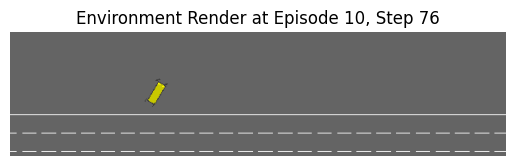

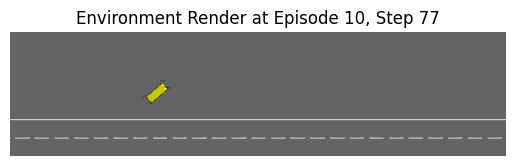

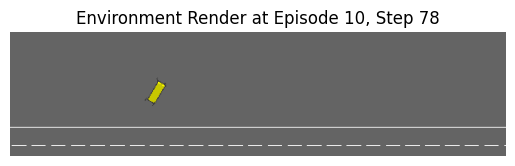

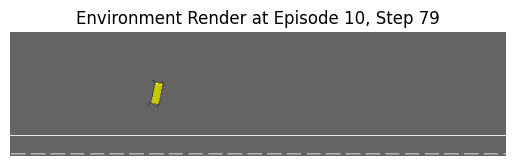

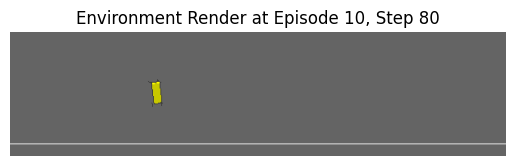

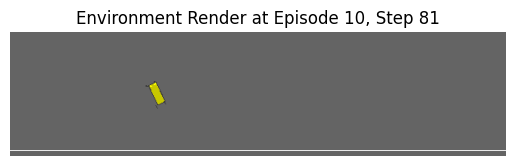

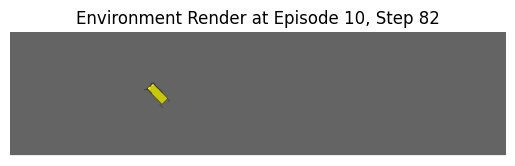

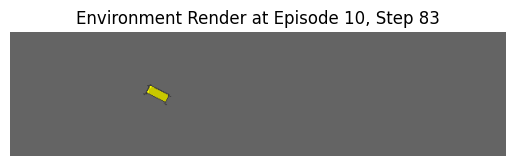

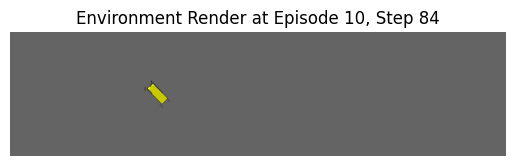

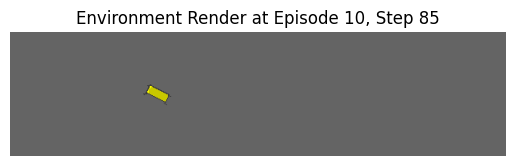

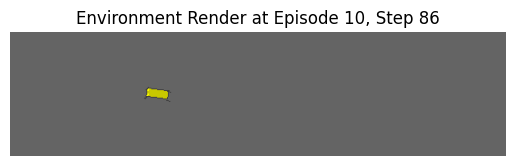

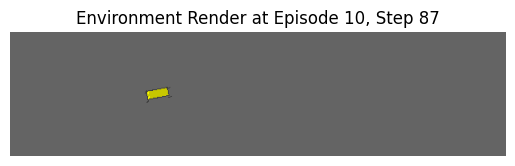

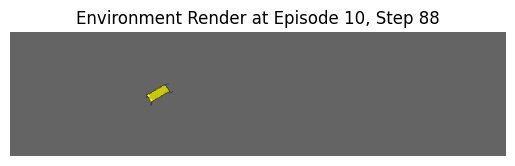

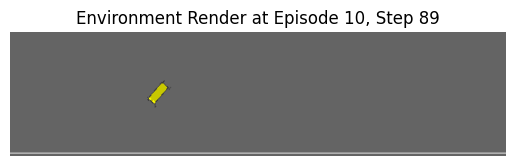

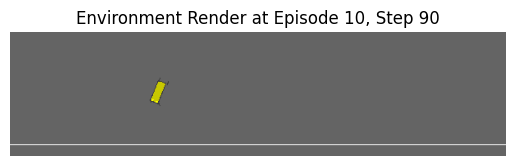

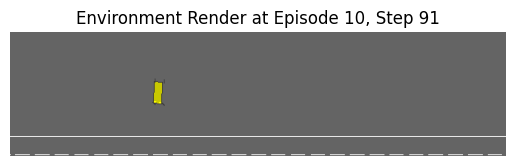

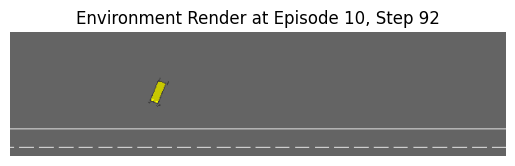

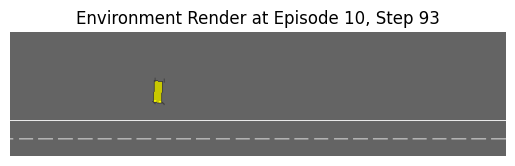

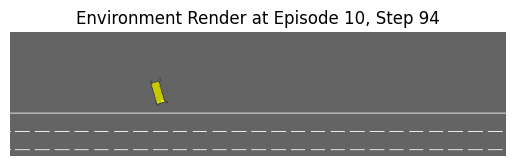

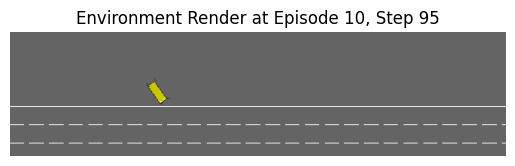

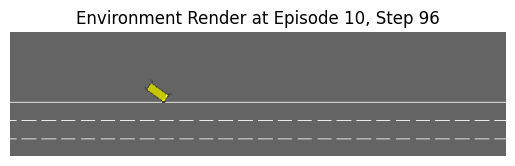

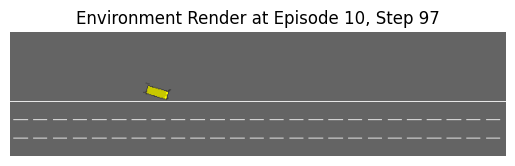

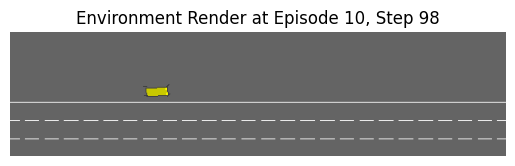

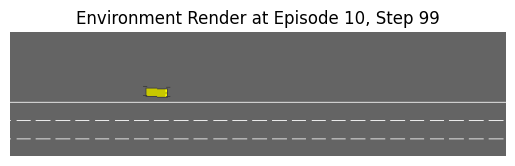

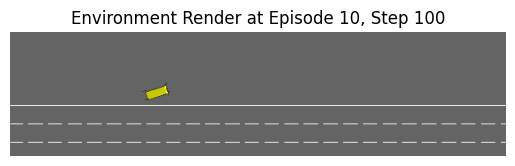

Episode 10 finished after 100 steps. Total Reward: -8714.67
Avg Loss (last 100 steps): 1633.0638


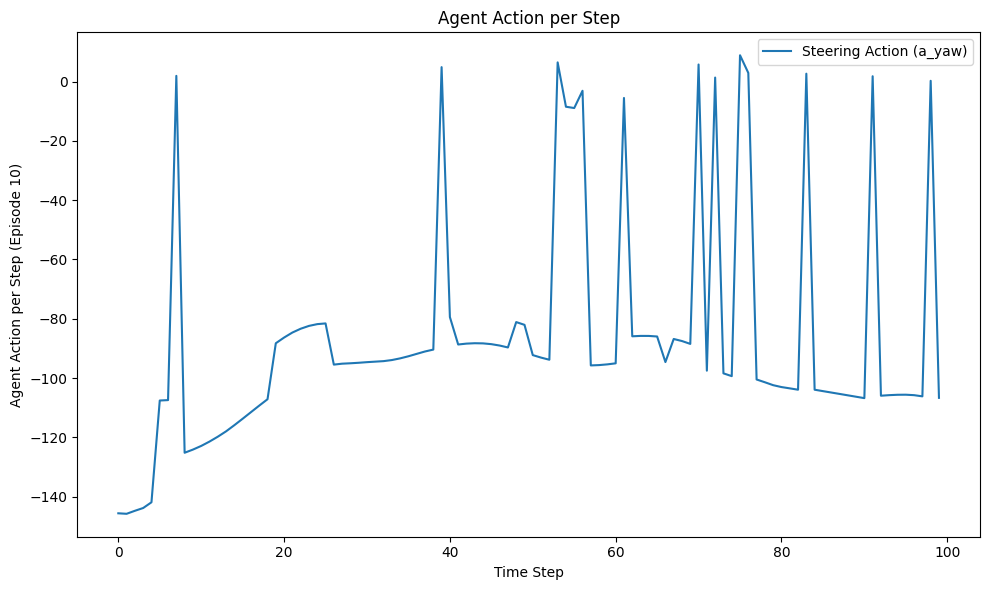

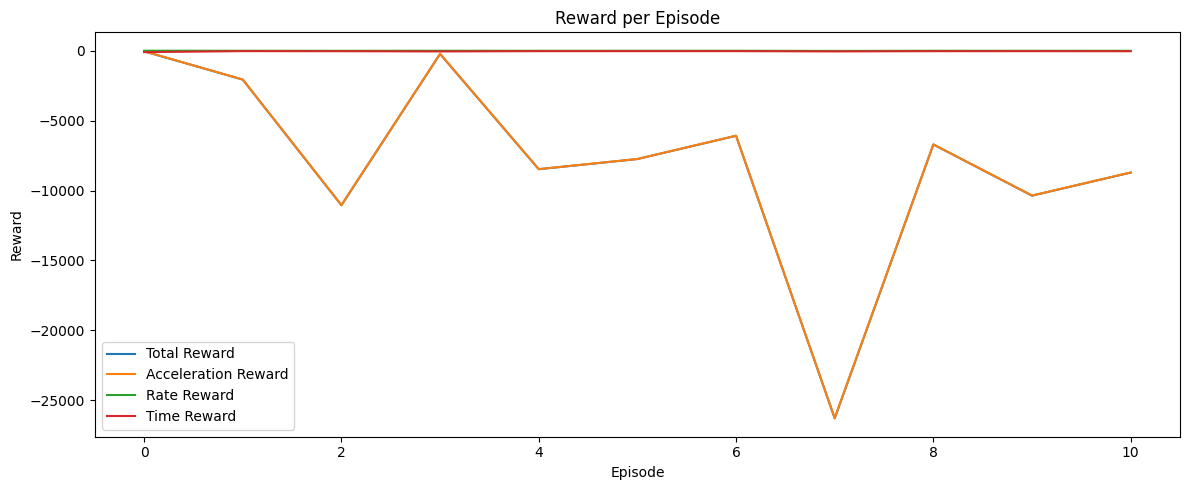

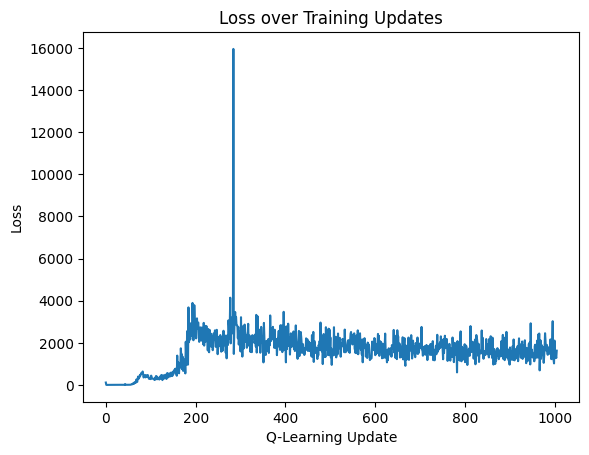

Episode 11 finished after 180 steps. Total Reward: -18850.90
Avg Loss (last 180 steps): 1560.8159
Episode 12 finished after 81 steps. Total Reward: -7652.07
Avg Loss (last 81 steps): 1477.6633
Episode 13 finished after 79 steps. Total Reward: -7614.07
Avg Loss (last 79 steps): 1500.0444
Episode 14 finished after 70 steps. Total Reward: -6825.92
Avg Loss (last 70 steps): 1500.3363
Episode 15 finished after 53 steps. Total Reward: -4924.75
Avg Loss (last 53 steps): 1434.7262
Episode 16 finished after 60 steps. Total Reward: -5945.54
Avg Loss (last 60 steps): 1412.3976
Episode 17 finished after 84 steps. Total Reward: -7735.32
Avg Loss (last 84 steps): 1405.0207


KeyboardInterrupt: 

In [47]:
################################################################################
"""Initialization"""
################################################################################
# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Set initial Input variables using the gap, current velocity, and relative lead velocity
input_variables = [lead_position_idm, ego_velocity_idm, lead_velocity_idm]

# Setup the IDM Model for Longitudinal control
ego_vehicle_idm = IDM(desired_parameters, control_parameters)

# Agent Initialization
lr = 0.01
gamma = 0.9
buffer_size = 10000
num_episodes = 10000
batch_size = 100
timesteps = 40000
update_target_frequency = 50
epsilon_decay_rate = 10000
target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)

threshold = 30

# Initialize Buffer
buffer = Experience_Buffer(buffer_size)

# Setup Lateral Control Agent
target_network = Agent(state_dim).to(device)
policy_network = Agent(state_dim).to(device)

# Initialize target network
target_network.load_state_dict(policy_network.state_dict())

# Loss and Criterion Initialization
policy_optimizer = torch.optim.Adam(policy_network.parameters(), lr=lr)
policy_loss_fn = nn.MSELoss()

# Tracking loss and Rewards values over training steps
loss_history = []
episode_rewards = []

total_steps_taken = 0

# Set plotting frequency (every X episodes)
plot_frequency = 10

################################################################################
"""Training & Testing Loop"""
################################################################################
for episodes in range(num_episodes):
    # Reset environment and state manager
    obs, _ = env.reset()
    state_manager = ENV(obs, 0.0)

    # Initial state information
    ego_state_idm = state_manager.ego_state_idm()
    lead_state = state_manager.longitudinal_lead_state()
    agent_state = state_manager.ego_state_agent(target_id=target_id)
    on_road_check = True
    collision_check = False

    # Agent activation flag and target lane storage
    activated_target_lane = None

    # Update IDM inputs based on initial state
    gap = lead_state['x']
    delta_velocity = lead_state['vx']
    input_variables = [gap, ego_state_idm['vx'], delta_velocity]

    steps = 0
    terminal = 0
    current_episode_reward = 0
    episode_acce_reward = 0
    episode_rate_reward = 0
    episode_time_reward = 0
    counter = 0
    epsilon = 0.1

    # For stepwise plotting, record agent actions per timestep
    episode_actions = []

    # Main loop for each episode
    while steps < timesteps and counter < 50:
        steps += 1

        if not on_road_check or collision_check:
            counter += 1

        # Epsilon decay based on total_steps_taken
        epsilon = max(0.05, 0.1 - (0.1 - 0.05) * (total_steps_taken / epsilon_decay_rate))

        # Recompute gap
        gap = lead_state['x']

        ########################################################################
        """Action Preparation"""
        ########################################################################
        gap_control = Gap_Controller(obs)
        activated_target_lane = gap_control.lane_checker(safety_threshold=threshold)

        # Determine target lane
        target_id = activated_target_lane
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        with torch.no_grad():
            agent_action = random.uniform(-10, 10) if random.random() < epsilon else policy_network.action(agent_state).item()

        # Store prior state for buffer
        old_state = agent_state
        obs_old = obs

        # IDM Longitudinal Control
        idm_acceleration = ego_vehicle_idm.longitudinal_controller(input_variables)
        longitudinal_control = idm_acceleration

        # Record the action for later stepwise plotting (e.g., steering angle per timestep)
        episode_actions.append(agent_action)

        # Transform agent action (acceleration prediction) to steering angle
        steering_angle = state_manager.steering_angle(agent_action, L)
        lateral_control = steering_angle

        # Combine longitudinal and lateral actions
        action = [longitudinal_control, lateral_control]

        ########################################################################
        """Data Collection"""
        ########################################################################
        obs, reward, done, truncated, info = env.step(action)

        # Check for off-road or collision events
        on_road_check = env.unwrapped.vehicle.on_road
        collision_check = info['crashed']

        # Terminal condition check
        if steps == timesteps or not on_road_check or collision_check:
            terminal = 1
        else:
            terminal = 0

        # Update state manager with new observation and applied longitudinal control
        state_manager = ENV(obs, longitudinal_control)
        # Compute reward based on the new state
        reward_per_episode = state_manager.reward_function(agent_action, obs_old, obs, target_id)

        # Reward Logging
        reward = reward_per_episode[0]
        current_episode_reward += reward
        episode_acce_reward += reward_per_episode[1]
        episode_rate_reward += reward_per_episode[2]
        episode_time_reward += reward_per_episode[3]

        ########################################################################
        """Update IDM Controller Inputs for next step"""
        ########################################################################
        ego_state_idm = state_manager.ego_state_idm()
        lead_state = state_manager.longitudinal_lead_state()
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        gap = lead_state['x']
        delta_velocity = lead_state['vx']
        input_variables = [gap, ego_state_idm['vx'], delta_velocity]

        # Update experience buffer
        buffer.add(old_state, agent_action, reward, agent_state, terminal)

        ########################################################################
        """Optional Stepwise Environment Render Plotting"""
        ########################################################################
        if episodes % plot_frequency == 0:
            plt.imshow(env.render())
            plt.title(f"Environment Render at Episode {episodes}, Step {steps}")
            plt.axis('off')
            plt.show()

        ########################################################################
        """Q-Learning Update"""
        ########################################################################
        if buffer.size() >= batch_size:
            rand_experience = buffer.sample_experience(batch_size=batch_size)
            transitions = torch.cat([t for t in rand_experience if isinstance(t, torch.Tensor)], dim=0).to(device)
            states, actions, rewards, next_states, terminals = torch.split(
                transitions, [state_dim, 1, 1, state_dim, 1], dim=1)

            current_q_values = policy_network(states, actions, terminals)
            with torch.no_grad():
                target_network.eval()
                next_state = torch.cat((next_states, terminals), dim=1)
                max_next_q_values = target_network.networkC(next_state)
            target_q_values = rewards + gamma * max_next_q_values * (1.0 - terminals)
            loss = policy_loss_fn(current_q_values, target_q_values)
            loss_history.append(loss.item())
            total_steps_taken += 1
            policy_optimizer.zero_grad()
            loss.backward()
            policy_optimizer.step()

    ############################################################################
    """Update Target Policy Network"""
    ############################################################################
    if episodes % update_target_frequency == 0:
        target_network.load_state_dict(policy_network.state_dict())
        print(f"**** Target network updated at episode {episodes} ****")

    # End of episode: store total reward values for logging
    episode_rewards.append([current_episode_reward, episode_acce_reward, episode_rate_reward, episode_time_reward])
    print(f"Episode {episodes} finished after {steps} steps. Total Reward: {current_episode_reward:.2f}")

    if len(loss_history) > 0 and total_steps_taken > 0:
        avg_loss_last_n = np.mean(loss_history[-steps:]) if steps > 0 else 0
        print(f"Avg Loss (last {steps} steps): {avg_loss_last_n:.4f}")

    ############################################################################
    """Periodic Plotting (every {} episodes)""".format(plot_frequency)
    ############################################################################
    if episodes % plot_frequency == 0 and episodes > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(episode_actions)), episode_actions, label="Steering Action (a_yaw)")
        plt.xlabel("Time Step")
        plt.ylabel(f"Agent Action per Step (Episode {episodes})")
        plt.legend()
        plt.title("Agent Action per Step")
        plt.tight_layout()
        plt.show()

        episode_rewards_arr = np.array(episode_rewards)
        plt.figure(figsize=(12, 5))
        plt.plot(range(len(episode_rewards_arr)), episode_rewards_arr[:, 0], label='Total Reward')
        plt.plot(range(len(episode_rewards_arr)), episode_rewards_arr[:, 1], label='Acceleration Reward')
        plt.plot(range(len(episode_rewards_arr)), episode_rewards_arr[:, 2], label='Rate Reward')
        plt.plot(range(len(episode_rewards_arr)), episode_rewards_arr[:, 3], label='Time Reward')
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("Reward per Episode")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure()
        plt.plot(loss_history)
        plt.xlabel("Q-Learning Update")
        plt.ylabel("Loss")
        plt.title("Loss over Training Updates")
        plt.show()